In [25]:
from src.nf import NormalizingFlowModel, MAF, CalibratedModel, neg_log_likelihood
from src.nf.classifiers import make_clf_dataset
from utils import data_utils

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

from catboost import CatBoostClassifier

from copy import deepcopy

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
data = data_utils.GAS()

In [12]:
dim = data.n_dims

In [20]:
X_train_tensor = torch.from_numpy(data.trn.x[:1000]).to(device)
X_test_tensor = torch.from_numpy(data.tst.x[:1000]).to(device)

In [21]:
prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = NormalizingFlowModel(dim, prior, [MAF(dim), MAF(dim)]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [22]:
epoches = 100
metrics_train, metrics_test = [], []

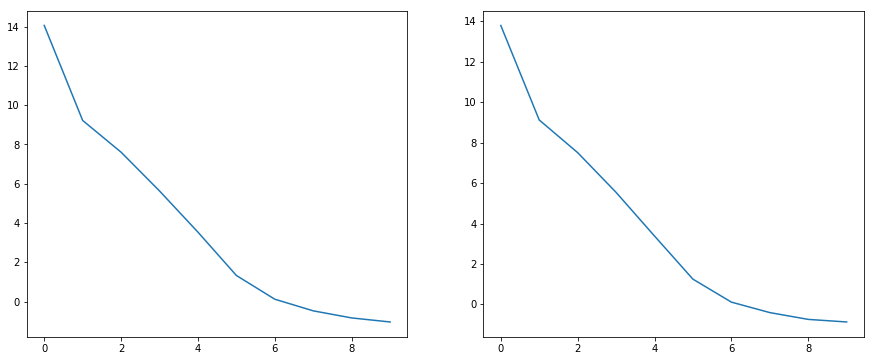

In [23]:
for epoch in range(len(metrics_train), epoches):
    loss = model.ll_train_step(optimizer, X_train_tensor)

    if epoch % 10 == 0:
        metrics_train.append(neg_log_likelihood(model, X_train_tensor))
        metrics_test.append(neg_log_likelihood(model, X_test_tensor))
        
        clear_output(False)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        axs[0].plot(np.arange(len(metrics_train)), metrics_train)
        axs[1].plot(np.arange(len(metrics_test)), metrics_test)

    plt.show()

In [26]:
clf_ds = make_clf_dataset(X_test_tensor, model)
clf_ds.shape

/Users/robdrynkin/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


(2000, 9)

In [28]:
clf = CatBoostClassifier(100)
clf.fit(clf_ds[:, :-1], clf_ds[:, -1], verbose=0)

In [30]:
calibrated_model = CalibratedModel(clf, model, logit=True)

In [31]:
samples = model.sample_n(1000)
new_samples = calibrated_model.sample_n(1000)

In [34]:
-neg_log_likelihood(model, samples), \
-neg_log_likelihood(calibrated_model, new_samples)

(1.0617120265960693, 1.535446478246555)